**This notebook is an exercise in the [Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability) course.  You can reference the tutorial at [this link](https://www.kaggle.com/dansbecker/shap-values).**

---


## Set Up

At this point, you have enough tools to put together compelling solutions to real-world problems. You will ned to pick the right techniques for each part of the following data science scenario. Along the way, you'll use SHAP values along with your other insights tools.

**The questions below give you feedback on your work by using some checking code. Run the following cell to set up our feedback system.**

In [42]:
# Get most recent checking code
!pip install -U -t /kaggle/working/ git+https://github.com/Kaggle/learntools.git
from learntools.ml_explainability.ex4 import *
print("Setup Complete")

  Cloning https://github.com/Kaggle/learntools.git to /tmp/pip-req-build-zea9mswk
  Running command git clone --filter=blob:none --quiet https://github.com/Kaggle/learntools.git /tmp/pip-req-build-zea9mswk
  fatal: unable to access 'https://github.com/Kaggle/learntools.git/': Could not resolve host: github.com
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/Kaggle/learntools.git /tmp/pip-req-build-zea9mswk did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/Kaggle/learntools.git /tmp/pip-req-build-zea9mswk did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Setup Complete


## The Scenario
A hospital has struggled with "readmissions," where they release a patient before the patient has recovered enough, and the patient returns with health complications. 

The hospital wants your help identifying patients at highest risk of being readmitted. Doctors (rather than your model) will make the final decision about when to release each patient; but they hope your model will highlight issues the doctors should consider when releasing a patient.

The hospital has given you relevant patient medical information.  Here is a list of columns in the data:


In [43]:
import pandas as pd
data = pd.read_csv('../input/hospital-readmissions/train.csv')
data.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

Here are some quick hints at interpreting the field names:

- Your prediction target is `readmitted`
- Columns with the word `diag` indicate the diagnostic code of the illness or illnesses the patient was admitted with. For example, `diag_1_428` means the doctor said their first illness diagnosis is number "428".  What illness does 428 correspond to? You could look it up in a codebook, but without more medical background it wouldn't mean anything to you anyway.
- A column names like `glimepiride_No` mean the patient did not have the medicine `glimepiride`. If this feature had a value of False, then the patient did take the drug `glimepiride`
- Features whose names begin with `medical_specialty` describe the specialty of the doctor seeing the patient. The values in these fields are all `True` or `False`.


## Your Code Library
As you write code to work through this scenario, these code snippets from previous tutorials may be useful. You'll still need to modify them, but we've copied them here to save you from having to look them up.

**Calculate and show permutation importance:**
```
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())
```

**Calculate and show partial dependence plot:**
```
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

feature_name = 'Goal Scored'
PartialDependenceDisplay.from_estimator(my_model, val_X, [feature_name])
plt.show()
```

**Calculate and show Shap Values for One Prediction:**
```
import shap  # package used to calculate Shap values

data_for_prediction = val_X.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)
```

## Step 1
You have built a simple model, but the doctors say they don't know how to evaluate a model, and they'd like you to show them some evidence the model is doing something in line with their medical intuition. Create any graphics or tables that will show them a quick overview of what the model is doing?

They are very busy. So they want you to condense your model overview into just 1 or 2 graphics, rather than a long string of graphics.

We'll start after the point where you've built a basic model. Just run the following cell to build the model called `my_model`.

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('../input/hospital-readmissions/train.csv')

y = data.readmitted

base_features = [c for c in data.columns if c != "readmitted"]

X = data[base_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X, train_y)

Now use the following cell to create the materials for the doctors.

In [45]:
# Your code here
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


For our idea of what to show, run the cell below.  

In [46]:
# Run this code cell to receive credit!
q_1.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
```python

# Use permutation importance as a succinct model summary
# A measure of model performance on validation data would be useful here too

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

```

If you'd like to discuss your approach or see what others have done, we have a discussion forum [here](https://www.kaggle.com/learn-forum/66267#latest-390149).



## Step 2

It appears `number_inpatient` is a really important feature. The doctors would like to know more about that. Create a graph for them that shows how `num_inpatient` affects the model's predictions.

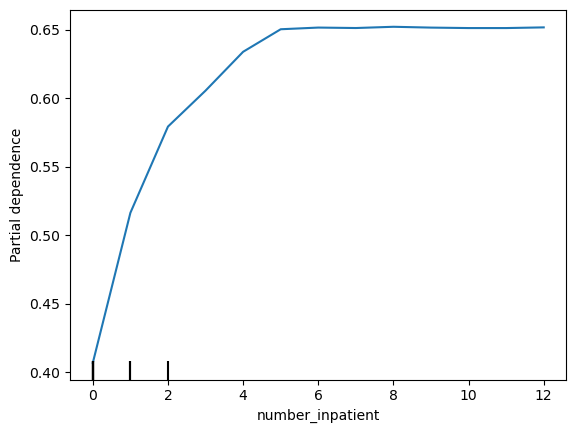

In [47]:
# Your Code Here
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(my_model, val_X, ['number_inpatient'])
plt.show()

For our solution, run the line below.

In [48]:
# Check your answer (Run this code cell to receive credit!)
# q_2.solution()

## Step 3

The doctors think it's a good sign that increasing the number of inpatient procedures leads to increased predictions.  But they can't tell from this plot whether that change in the plot is big or small. They'd like you to create something similar for `time_in_hospital` to see how that compares.

In [ ]:
# Your Code Here
import shap  # package used to calculate Shap values

data_for_prediction = val_X.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)


Uncomment the relevant line below to see one solution.

In [ ]:
# Check your answer (Run this code cell to receive credit!)
q_3.solution()

## Step 4

Woah!  It seems like `time_in_hospital` doesn't matter at all.  The difference between the lowest value on the partial dependence plot and the highest value is about 5%.

If that is what your model concluded, the doctors will believe it. But it seems so low. Could  the data be wrong, or is your model doing something more complex than they expect?  

They'd like you to show them the raw readmission rate for each value of `time_in_hospital` to see how it compares to the partial dependence plot.

- Make that plot. 
- Are the results similar or different?

In [ ]:
# Your Code Here

data.groupby(['time_in_hospital']).mean().readmitted.plot()
plt.show()

For a hint, uncomment the line below.

In [ ]:
q_4.hint()

In [ ]:
# Check your answer (Run this code cell to receive credit!)
q_4.solution()

## Step 5
Now the doctors are convinced you have the right data, and the model overview looked reasonable.  It's time to turn this into a finished product they can use. Specifically, the hospital wants you to create a function `patient_risk_factors` that does the following
- Takes a single row with patient data (of the same format you as your raw data)
- Creates a visualization showing what features of that patient increased their risk of readmission, what features decreased it, and how much those features mattered.

It's not important to show every feature with every miniscule impact on the readmission risk.  It's fine to focus on only the most important features for that patient.

In [ ]:
# Your Code Here
import shap  # package used to calculate Shap values


def patient_risk_factors(model, patient_data):
    # Create object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient_data)

sample_data_for_prediction = val_X.iloc[0].astype(float) 

patient_risk_factors(my_model,sample_data_for_prediction)


For a hint, uncomment the line below.

In [ ]:
# q_5.hint()

In [ ]:
# Check your answer (Run this code cell to receive credit!)
q_5.solution()

## Keep Going
You have some powerful tools to get insights about both models and individual predictions. Next you will look at **[aggregations of SHAP values](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)** to link the model-level and prediction-level insights.


---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/machine-learning-explainability/discussion) to chat with other learners.*